# 0. Installing and importing dependencies

In [1]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            2.0.0
alabaster                          0.7.12
ale-py                             0.8.1
anaconda-client                    1.9.0
anaconda-navigator                 2.1.2
anaconda-project                   0.10.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
arrow                              0.13.1
asn1crypto                         1.4.0
astroid                            2.6.6
astropy                            4.3.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              21.2.0
autopep8                           1.5.7
AutoROM                            0.6.1
AutoROM.accept-rom-license         0.6.1
Babel                              


Pygments                           2.16.1
PyJWT                              2.1.0
pylint                             2.9.6
pyls-spyder                        0.4.0
PyNaCl                             1.4.0
pyodbc                             4.0.0-unsupported
pyOpenSSL                          21.0.0
pyparsing                          3.0.4
pyreadline                         2.1
pyrsistent                         0.18.0
PySocks                            1.7.1
pytest                             6.2.4
python-dateutil                    2.8.2
python-lsp-black                   1.0.0
python-lsp-jsonrpc                 1.0.0
python-lsp-server                  1.2.4
python-slugify                     5.0.2
python-version                     0.0.2
pytz                               2021.3
PyWavelets                         1.1.1
pywin32                            228
pywin32-ctypes                     0.2.0
pywinpty                           0.5.7
PyYAML                             6.0
pyzmq

In [2]:
#!pip uninstall tensorflow

In [3]:
#!pip install opencv-python matplotlib imageio gdown tensorflow==2.9.1

In [4]:
#!pip install numpy==1.22.4 --user

In [57]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import glob
import gdown
import sys

In [58]:
#listing python version for reproducibility
print(sys.version)

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


In [6]:
os.getcwd()

'C:\\Users\\stefd\\notebook projects'

In [7]:
#listing tensorflow version for reproducibility
tf.__version__

'2.9.1'

In [8]:
#list the available gpu devices
gpu = tf.config.list_physical_devices('GPU')
print("available gpus:", gpu)

available gpus: []


# 1. Building function of data loading

In [9]:
#download the dataset of original lipnet as a zip, then extract it in a folder
#url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
#output = 'dataset.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall('dataset.zip')

In [10]:
def load_video(path: str) -> List[float]:
    # Open the video file specified by the path
    cap = cv2.VideoCapture(path)
    
    # Initialize a list to store preprocessed video frames
    frames = []
    
    # Iterate through the frames in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        
        # Convert the frame to grayscale
        frame = tf.image.rgb_to_grayscale(frame)
        
        # Crop the frame to a specific region of interest (ROI)
        roi = frame[180:236, 80:240, :]
        
        # Calculate the mean and standard deviation of the ROI
        mean = tf.math.reduce_mean(roi)
        std = tf.math.reduce_std(tf.cast(roi, tf.float32))
        
        # Normalize the ROI by subtracting the mean and dividing by the standard deviation
        normalized_frame = tf.cast((roi - mean), tf.float32) / std
        
        frames.append(normalized_frame)
    
    # Release the video capture object
    cap.release()
    
    # Return the preprocessed and normalized frames as a list of floating-point numbers
    return frames

In [11]:
# Create a list of characters representing the vocabulary.
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [12]:
#this is the solution of the original lipnet paper 
# Define a StringLookup layer to map characters to numerical values
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

# Define another StringLookup layer to map numerical values back to characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

# Print information about the vocabulary and its size
vocabulary = char_to_num.get_vocabulary()
vocabulary_size = char_to_num.vocabulary_size()
print(f"The vocabulary is: {vocabulary} (size = {vocabulary_size})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


In [13]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [14]:
char_to_num(['s','t','e','f'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([19, 20,  5,  6], dtype=int64)>

In [15]:
num_to_char([19,  20,  5, 6])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b's', b't', b'e', b'f'], dtype=object)>

In [16]:
#loading alignments from path
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()

#running a for loop to remove the silence from dataset.
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])
            
            # Convert the filtered tokens to numerical values using 'char_to_num' and reshape the data. Exclude the first element.
            return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [17]:
# Load data from the specified file path
def load_data(path: str):
    # Decode the 'path' from bytes to a string
    path = bytes.decode(path.numpy())
    
    # Extract the file name from the path
    # Note: The file path is expected to have either '/' or '\' as a separator
    file_name = path.split('\\')[-1].split('.')[0]#path.split('/')[-1].split('.')[0]
    print(file_name)
    
    # Construct paths for video and alignment files based on the file name
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    print(alignment_path)
    
    # Load video frames from the video file path
    frames = load_video(video_path)
    
    # Load alignments data from the alignment file path
    alignments = load_alignments(alignment_path)
    
    # Return the loaded video frames and alignments
    return frames, alignments


In [18]:
test_path = '.\\data\\alignments\\s1\\bbal6n.mpg'

In [19]:
# Load data from the specified 'test_path' using the 'load_data' function and converting it to tensor
frames, alignments = load_data(tf.convert_to_tensor(test_path))

bbal6n
data\alignments\s1\bbal6n.align


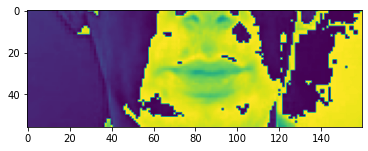

In [20]:
plt.imshow(frames[22])

In [21]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n']


In [22]:
# Convert numerical alignments to strings and join them into a single string
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin'>

In [23]:
# Load and process data from the specified 'path' using 'load_data' and return the result
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [24]:
mpg_directory = '.\\data\\s1\\'

# List all MPG files in the directory
mpg_files = glob.glob(os.path.join(mpg_directory, '*.mpg'))

# Print the number of MPG files
num_mpg_files = len(mpg_files)
print(f'Number of MPG files: {num_mpg_files}')


Number of MPG files: 1000


In [25]:
# Directory containing .align files
align_directory = '.\\data\\alignments\\s1\\'

# List all .align files in the directory
align_files = glob.glob(os.path.join(align_directory, '*.align'))

# Print the number of .align files
num_align_files = len(align_files)
print(f'Number of .align files: {num_align_files}')

Number of .align files: 1000


# 2 Creating a data pipeline

In [26]:
#shuffle data, allow it to be mapped, prefetched and padded in sets of 2
#*i use small batches for training stability and efficiency
data = tf.data.Dataset.list_files('.\\data\\s1\\*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [27]:
total_samples = tf.data.experimental.cardinality(data).numpy()

print("Total samples:", total_samples)

Total samples: 500


In [28]:
total_samples = 500
train_ratio = 0.8

# Calculate the number of samples for training and testing
train_samples = int(train_ratio * total_samples)
test_samples = total_samples - train_samples


# For training data
train = data.take(train_samples)

# For testing data
test = data.skip(train_samples).take(test_samples)

In [29]:
frames, alignments = data.as_numpy_iterator().next()

pric3s
data\alignments\s1\pric3s.align
bbal9a
data\alignments\s1\bbal9a.align
prii9a
data\alignments\s1\prii9a.align


In [30]:
len(frames)

2

In [31]:
alignments

array([[16, 12,  1,  3,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [32]:
test = data.as_numpy_iterator()

In [33]:
value = test.next(); value[0]

lgwt2p
data\alignments\s1\lgwt2p.align
swbi7a
data\alignments\s1\swbi7a.align


array([[[[[ 1.6405776 ],
          [ 1.6405776 ],
          [ 1.5995631 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.5995631 ],
          [ 1.5995631 ],
          [ 1.5995631 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.5995631 ],
          [ 1.5995631 ],
          [ 1.5995631 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.94333214],
          [ 0.94333214],
          [ 0.94333214],
          ...,
          [10.089552  ],
          [10.089552  ],
          [10.089552  ]],

         [[ 0.94333214],
          [ 0.94333214],
          [ 0.94333214],
          ...,
          [10.089552  ],
          [10.089552  ],
          [10.089552  ]],

         [[ 0.94333214],
          [ 0.94333214],
          [ 0.94333214],
          ...,
          [10.089552  ],
          [10.048538  ],
          

sgbc6n
data\alignments\s1\sgbc6n.align


In [34]:
#creates an video.gif file which shows what the model will see and train off
#imageio.mimsave('./video.gif', value[0][1], fps=8)

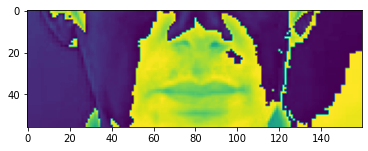

In [35]:
# 0: give me videos, 1: give second video of the batch, 2: return frame 3 of video (75 frames total)
plt.imshow(value[0][1][2])

In [36]:
tf.strings.reduce_join([num_to_char(word) for word in value[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay'>

# 3 Designing the Deep Neural Network


In [37]:
#importing model, layers, optimizers and callbacks
#https://github.com/asmith26/my_keras_doc/blob/master/docs/templates/getting-started/sequential-model-guide.md
#https://github.com/christianversloot/machine-learning-articles/blob/main/a-simple-conv3d-example-with-keras.md
#chatgpt bijlage
#https://arxiv.org/abs/1611.01599
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool3D, BatchNormalization, Activation, Reshape, Conv3D, LSTM, Dense, Dropout, SpatialDropout3D, TimeDistributed, BatchNormalization,  Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
#Layer explanation
# Conv3D, highlights important information like edges or patterns, will be run twice with different amount of layers
# MaxPool3D, Picks out the most important information from the frames, will be run twice with different amount of layers
# Timedistributed and Flatten, arranges frames into a neat sequence, turns multidimensional input into 1 dimensional input
# Dropout, sometimes forgets certain parts of data to make sure model doesnt hyperfixate on specific details
# LSTM, long-short-term-memory, remembers important stuff, forgets the rest
# Batchnormalization, helps stabilize and accelerate training by normalizing the inputs to a layer
# Dense, allows communication between the neurons of the neural network


In [38]:
# getting the shape to use as input for the Conv3D Layers
data.as_numpy_iterator().next()[0][0].shape

pwixzn
data\alignments\s1\pwixzn.align
bwbt8p
data\alignments\s1\bwbt8p.align
bwat4p
data\alignments\s1\bwat4p.align
lgas3s
data\alignments\s1\lgas3s.align


(75, 56, 160, 1)

In [39]:
sample_shape = (75, 56, 160, 1)

In [40]:
# 3D CNN model with a convolutional layer, followed by a 3D max pooling layer.
model = Sequential()
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape, padding='same'))
model.add(MaxPool3D((1, 2, 2)))

# another Conv3D layer with 256 filters, followed by another 3D max pooling layer.
model.add(Conv3D(256, 3, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool3D((1, 2, 2)))

# Applies TimeDistributed layer to flatten the output of the previous layer along the temporal dimension.
model.add(TimeDistributed(Flatten()))

# LSTM layers with dropout and batchnormalization
model.add(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Dense (fully connected) layer with a number of units equal to the vocabulary size plus one (for an additional class)
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 56, 160, 128)  3584      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 28, 80, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 28, 80, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 14, 40, 256)  0         
 3D)                                                             
                                                                 
 time_distributed (TimeDistr  (None, 75, 143360)       0         
 ibuted)                                                         
                                                        

In [42]:
# Making predictions using the trained model on input data 'value[0]'. 'yhat' contains the model's predicted probabilities for different classes.
yhat = model.predict(value[0])

1/1 [==============================] - 5s 5s/step


In [43]:
model.input_shape

(None, 75, 56, 160, 1)

In [44]:
model.output_shape

(None, 75, 41)

In [45]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnoonnnnnnnyyvnnnnnnnnvnnnnnnnnnnnvvvvvnnnv'>

In [46]:
yhat[0].shape

(75, 41)

# 4 training setup options and training


In [47]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [48]:
#custom schedule function, after epoch 20 exponentially decreases the learning rate
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.09)

In [49]:
#https://keras.io/examples/audio/ctc_asr/#model
#using CTCloss to reduce the need for 1 to 1 alignment, even though our current dataset is aligned, its necesarry if used on non aligned data.
def CTCLoss(y_true, y_pred):
    batch_len = tf.shape(y_true)[0]
    input_length = tf.shape(y_pred)[1]
    label_length = tf.shape(y_true)[1]

    input_length = tf.fill((batch_len, 1), input_length)
    label_length = tf.fill((batch_len, 1), label_length)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [50]:
#creating a calculate_ser and wer function, as additional metrics to eveluate performance.
def calculate_ser(y_true, y_pred):
    # Assuming y_true and y_pred are sequences of symbols (e.g., characters or words)
    errors = sum(1 for true, pred in zip(y_true, y_pred) if true != pred)
    total_symbols = len(y_true)
    ser = errors / total_symbols
    return ser

def calculate_wer(y_true, y_pred):
    # Assuming y_true and y_pred are sequences of words
    true_words = set(y_true.split())
    pred_words = set(y_pred.split())
    
    common_words = true_words.intersection(pred_words)
    total_words = len(true_words) + len(pred_words) - len(common_words)
    
    wer = (total_words - len(common_words)) / total_words
    return wer

In [51]:
#prints original and predicted sequences, using a CTC-decoded representation, for each example in the dataset at the end of each training epoch.
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = data.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for example_idx in range(len(yhat)):           
            original_sequence = tf.strings.reduce_join(num_to_char(data[1][example_idx])).numpy().decode('utf-8')
            predicted_sequence = tf.strings.reduce_join(num_to_char(decoded[example_idx])).numpy().decode('utf-8')

            print('Original:', original_sequence)
            print('Prediction:', predicted_sequence)
            print('~' * 100)

In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CTCLoss)

In [53]:
#callback saves the model's weights to the specified directory when training, 
#based on the optimization of the monitored loss metric, and only saves the weights if they improve
checkpoint_callback = ModelCheckpoint(
    r'C:\Users\stefd\notebook projects\models\checkpoints',
    monitor='loss',
    save_best_only=True,
    save_weights_only=True
)

In [54]:
schedule_callback = LearningRateScheduler(scheduler)

In [55]:
example_callback = ProduceExample(test)

In [56]:
#model.fit(train, validation_data=test, epochs=55, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5 making a prediction

# 6 testing the model on the data